## 1. Proses Importing

### 1.1 Import Beberapa Package Penting


In [3]:
from random import seed, randrange, random
import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer, OrdinalEncoder
from math import exp
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools

### 1.2 Mengimport Dataset



Dataset yang digunakan adalah [Employee Dataset](https://www.kaggle.com/datasets/tawfikelmetwally/employee-dataset/) dari Kaggle. Dataset ini mengandung informasi mengenai background edukasi, tahun bergabung dan banyak fitur lain menyangkut tentang karyawan. Tugas saya adalah untuk melatih model untuk memprediksi dimasa mendatang apakah ia akan keluar dari perusahaan atau tidak.

In [4]:
file_path = "/Datasets/Employee.csv"
dataset = pd.read_csv(file_path)
dataset

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1
...,...,...,...,...,...,...,...,...,...
4648,Bachelors,2013,Bangalore,3,26,Female,No,4,0
4649,Masters,2013,Pune,2,37,Male,No,2,1
4650,Masters,2018,New Delhi,3,27,Male,No,5,1
4651,Bachelors,2012,Bangalore,3,30,Male,Yes,2,0


In [5]:
X = dataset.drop(columns="LeaveOrNot")
y = dataset.LeaveOrNot

## 2. Preprocessing Data

### 2.1 Transformasi Data Categorical dan Normalisasi Data

In [6]:
ordinal_data = OrdinalEncoder().fit_transform(X.select_dtypes(include="object"))
numerical_data = Normalizer().fit_transform(X.select_dtypes(include="number"))
X = np.concatenate([ordinal_data, numerical_data], axis=1)

In [7]:
dataset = pd.concat([pd.DataFrame(X), y], axis =1).values.tolist()

### 2.2 Mengubah target dari float menjadi integer

In [8]:
def str_column_to_int(dataset, column):
	class_values = [row[column] for row in dataset]
	unique = set(class_values)
	lookup = dict()
	for i, value in enumerate(unique):
		lookup[value] = i
	for row in dataset:
		row[column] = lookup[row[column]]
	return lookup
str_column_to_int(dataset, len(dataset[0])-1)

{0.0: 0, 1.0: 1}

### 2.3 Memisahkan dataset ke n folds untuk cross validation

In [9]:
def cross_validation_split(dataset, n_folds):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	for i in range(n_folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split


### 2.4 Membuat Perhitungan Persentase Akurasi 

In [10]:
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0


### 2.5 Membuat Fungsi Evaluasi Algoritma Menggunakan Cross Validation Split

In [11]:
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = list()
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in fold]
		accuracy = accuracy_metric(actual, predicted)
		scores.append(accuracy)
	return scores, actual, predicted


## 3. Forward Propagate

### 3.1 Menghitung Input untuk Neuro Activation

In [12]:
def activate(weights, inputs):
	activation = weights[-1]
	for i in range(len(weights)-1):
		activation += weights[i] * inputs[i]
	return activation


### 3.2 Transfer Neuron Activation

In [13]:
def Sigmoid(activation):
	return 1.0 / (1.0 + exp(-activation))

### 3.3 Forward Propagate Input pada Output Network

In [14]:
def forward_propagate(network, row):
	inputs = row
	for layer in network:
		new_inputs = []
		for neuron in layer:
			activation = activate(neuron['weights'], inputs)
			neuron['output'] = Sigmoid(activation)
			new_inputs.append(neuron['output'])
		inputs = new_inputs
	return inputs

## 4. Back Propage Error

### 4.1 Menghitung Derivative dari Output Neuron

In [15]:
def transfer_derivative(output):
	return output * (1.0 - output)

### 4.2 Backpropagate error dan masukkan dalam neurons

In [16]:
def backward_propagate_error(network, expected):
	for i in reversed(range(len(network))):
		layer = network[i]
		errors = list()
		if i != len(network)-1:
			for j in range(len(layer)):
				error = 0.0
				for neuron in network[i + 1]:
					error += (neuron['weights'][j] * neuron['delta'])
				errors.append(error)
		else:
			for j in range(len(layer)):
				neuron = layer[j]
				errors.append(neuron['output'] - expected[j])
		for j in range(len(layer)):
			neuron = layer[j]
			neuron['delta'] = errors[j] * transfer_derivative(neuron['output'])

## 5. Training Network

### 5.1 Update weight network dengan error dari backpropagate

In [17]:
def update_weights(network, row, l_rate):
	for i in range(len(network)):
		inputs = row[:-1]
		if i != 0:
			inputs = [neuron['output'] for neuron in network[i - 1]]
		for neuron in network[i]:
			for j in range(len(inputs)):
				neuron['weights'][j] -= l_rate * neuron['delta'] * inputs[j]
			neuron['weights'][-1] -= l_rate * neuron['delta']


### 5.2 Train network berdasarkan jumlah epoch

In [26]:
def train_network(network, train, l_rate, n_epoch, n_outputs):
	for epoch in range(n_epoch):
		sum_error = 0
		for row in train:
			outputs = forward_propagate(network, row)
			expected = [0 for i in range(n_outputs)]
			expected[row[-1]] = 1
			sum_error += sum([(expected[i]-outputs[i])**2 for i in range(len(expected))])
			backward_propagate_error(network, expected)
			update_weights(network, row, l_rate)

## 6. Inisialisasi Network

In [19]:
def initialize_network(n_inputs, n_hidden, n_outputs):
	network = list()
	hidden_layer = [{'weights':[random() for i in range(n_inputs + 1)]} for i in range(n_hidden)]
	network.append(hidden_layer)
	output_layer = [{'weights':[random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
	network.append(output_layer)
	return network

## 7. Prediksi

### 7.1 Melakukan prediksi dengan network yang sudah di training

In [20]:
def predict(network, row):
	outputs = forward_propagate(network, row)
	return outputs.index(max(outputs))

### 7.2 Membuat Fungsi untuk Menggambar Confusion Matrix

In [21]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()
	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)
	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')
	else:
		print('Confusion Matrix, Without Normalization')
	print(cm)
	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

# Algoritma Backpropagasi

In [22]:
def back_propagation(train, test, l_rate, n_epoch, n_hidden):
	n_inputs = len(train[0]) - 1
	n_outputs = len(set([row[-1] for row in train]))
	network = initialize_network(n_inputs, n_hidden, n_outputs)
	train_network(network, train, l_rate, n_epoch, n_outputs)
	predictions = list()
	for row in test:
		prediction = predict(network, row)
		predictions.append(prediction)
	return(predictions)

# Training Algoritma Backpropagasi

In [27]:
seed(1)
n_folds = 3 
l_rate = 0.001 
n_epoch = 100
n_hidden = 100
scores, actual, predicted = evaluate_algorithm(dataset, back_propagation, n_folds, l_rate, n_epoch, n_hidden)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Confusion Matrix, Without Normalization
[[580  44]
 [173 133]]


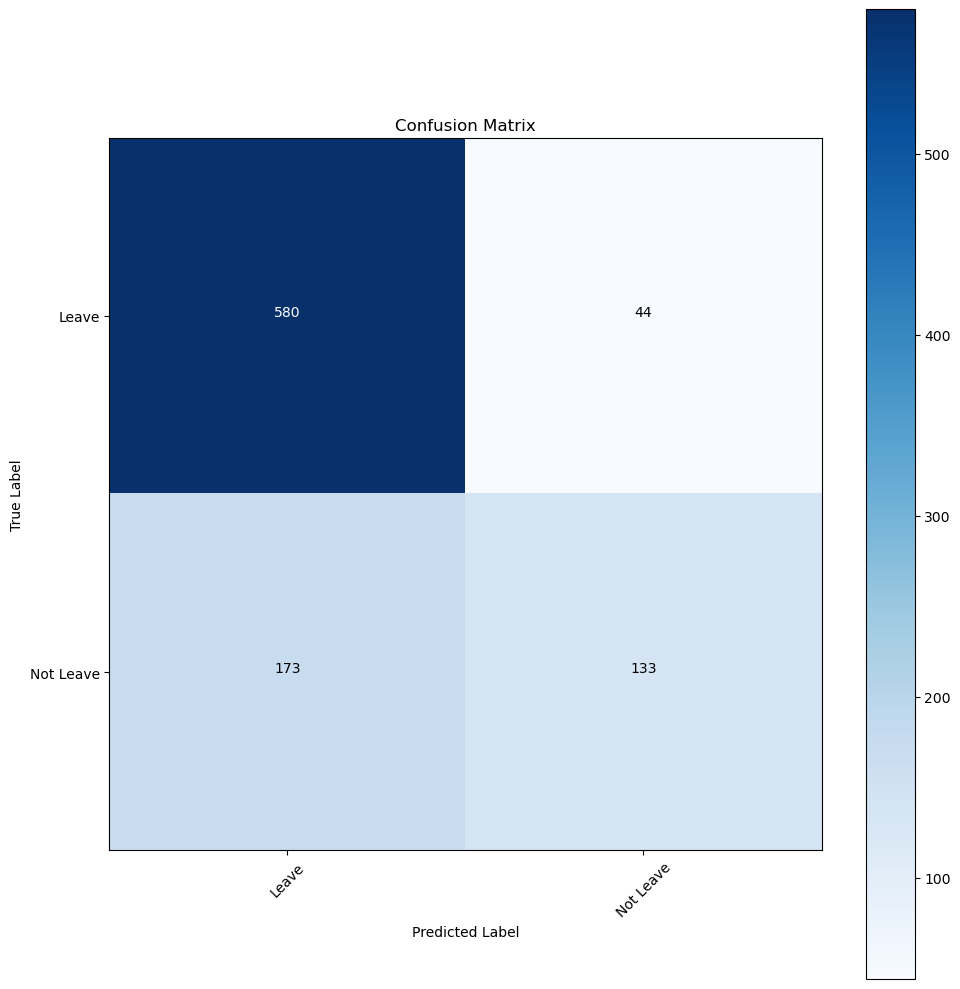

In [24]:
cm = confusion_matrix(actual, predicted)
plot_confusion_matrix(cm = cm, classes = ["Leave", "Not Leave"])

In [25]:
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

           0       0.77      0.93      0.84       624
           1       0.75      0.43      0.55       306

    accuracy                           0.77       930
   macro avg       0.76      0.68      0.70       930
weighted avg       0.76      0.77      0.75       930

